In [26]:

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
import numpy as np
import math
import matplotlib.pyplot as plt

# open csv

In [27]:
# open preprocessed data
df = pd.read_csv('../data/processed_reviews.csv')
without_dupe = df.drop_duplicates(subset=['review_text'], inplace=False)
# select subcategory to analyze
subcategory = 'BODY CARE BODY LOTION'

label = "body_lotion"
df = df[df['subcategory'] == subcategory]
print(df.shape)
df.head()

(20281, 10)


,brand,product_title,proxy_date,retailer,category,subcategory,review_text,star_rating,topic,brand_type
210565,Palmer's,Palmer's Cocoa Butter Formula Daily Skin Thera...,2024-07-01,CVS,PERSONAL CARE,BODY CARE BODY LOTION,i have use this lotion for year and love it ve...,5.0,Moisturizer preference and usage habits,Competitor
210757,EOS,eos Shea Better Moisture Body Lotion - Vanilla...,2024-07-01,Target,PERSONAL CARE,BODY CARE BODY LOTION,ive be look for a new body lotion from a compa...,3.0,Positive reviews for a makeup remover (undeter...,Competitor
210829,Eucerin,Eucerin Intensive Repair Very Dry Skin Lotion ...,2024-07-01,Amazon,PERSONAL CARE,BODY CARE BODY LOTION,this lotion be a must have if you have dry ski...,5.0,Positive reviews for a makeup remover (undeter...,Competitor
210925,Medix 5.5,Medix 5.5 Retinol Body Lotion Firming Moisturi...,2024-07-01,Amazon,PERSONAL CARE,BODY CARE BODY LOTION,no retinol list on ingredient list,1.0,Positive reviews for a makeup remover (undeter...,Competitor
211032,Medix 5.5,Medix 5.5 Retinol Body Lotion Firming Moisturi...,2024-07-01,Amazon,PERSONAL CARE,BODY CARE BODY LOTION,i love this lotion lovely scent it have bright...,5.0,Positive reviews for a makeup remover (undeter...,Competitor


In [28]:
# group reviews by subcategory and make dictrionary with rating: review_text
grouped = df.groupby('star_rating').apply(lambda x: x['review_text'].tolist()).to_dict()

/var/folders/x2/lsyflj4j07jc1sb3w3hfgmjc0000gn/T/ipykernel_24053/719716116.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('star_rating').apply(lambda x: x['review_text'].tolist()).to_dict()


In [29]:
def get_number_topics(num_reviews):
    if num_reviews > 50000:
        return 20
    if num_reviews > 25000:
        return 15
    if num_reviews > 10000:
        return 10
    if num_reviews > 5000:
        return 8
    if num_reviews > 1000:
        return 6
    if num_reviews > 500:
        return 5
    if num_reviews > 100:
        return 4
    if num_reviews > 50:
        return 3
    if num_reviews > 10:
        return 2
    return 1
total_topics = get_number_topics(df.shape[0])
total_topics

10

In [30]:
def calculate_num_topics(group_size, total_size, total_topics, rating, min_topics=1):
    rating_weights = {1: 1.5, 2: 1.25, 3: 1.0, 4: 0.75, 5: 0.5}
    weights_sum = sum(rating_weights.values())
    
    # proportional based on total group size
    proportion = group_size / total_size * 0.4 + rating_weights[rating] / weights_sum * 0.6
    
    # calculate the number of topics --> at least 1 per group
    num_topics = max(min_topics, math.floor(proportion * total_topics)) if rating > 2 else max(min_topics, math.ceil(proportion * total_topics))
    return num_topics

total = df.shape[0]
cur_num_topics = 0
for i in range(1, 6):
    print(f'num topics for rating {i} with {len(grouped[i])} reviews:')
    print(calculate_num_topics(len(grouped[i]), total, total_topics, i))
    cur_num_topics += calculate_num_topics(len(grouped[i]), total, total_topics, i)
print(cur_num_topics)


num topics for rating 1 with 1525 reviews:
3
num topics for rating 2 with 666 reviews:
2
num topics for rating 3 with 1059 reviews:
1
num topics for rating 4 with 2597 reviews:
1
num topics for rating 5 with 14434 reviews:
3
10


# BERTopic models

In [31]:
def create_topic_model(text, subcategory, rating):
    # Step 1 - Extract embeddings
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

    # Step 2 - Reduce dimensionality
    umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine')

    # Step 3 - Cluster reduced embeddings
    hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True, allow_single_cluster=True)

    # Step 4 - Tokenize topics
    vectorizer_model = CountVectorizer(stop_words="english")

    # Step 5 - Create topic representation
    ctfidf_model = ClassTfidfTransformer()

    # Step 6 - (Optional) Fine-tune topic representations with 
    # a `bertopic.representation` model
    representation_model = KeyBERTInspired()

    topic_model = BERTopic(
        embedding_model=embedding_model,          # Step 1 - Extract embeddings
        umap_model=umap_model,                    # Step 2 - Reduce dimensionality
        hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
        vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
        ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
        representation_model=representation_model # Step 6 - (Optional) Fine-tune topic representations
    )

    # Fit BERTopic model
    topic_model.fit_transform(text)
    topic_model.save(f'bertopic_models/{subcategory}_topic_model_{rating}.pickle')
    return topic_model

## took 2 min 6 s

In [32]:
models = {}
for rating, reviews in grouped.items():
    # if model already exists, load it
    try:
        model = BERTopic.load(f'bertopic_models/{subcategory}_topic_model_{rating}.pickle')
        models[rating] = model
        print(f'Loaded model for rating {rating}')
        continue
    except:
        print(f'Rating {rating} with {len(reviews)} reviews')
        models[rating] = create_topic_model(reviews, subcategory, rating)
        print('\n')

Loaded model for rating 1.0
Loaded model for rating 2.0
Loaded model for rating 3.0
Loaded model for rating 4.0
Loaded model for rating 5.0


## number of topics generated per rating

In [33]:
for rating, model in models.items():
    print(f'Rating {rating} with {len(model.get_topic_freq())} topics')
    print(model.get_topic_freq())
    print('\n')

Rating 1.0 with 2 topics
   Topic  Count
0      0   1515
1     -1     10


Rating 2.0 with 2 topics
   Topic  Count
0      0    651
1     -1     15


Rating 3.0 with 2 topics
   Topic  Count
0      0    962
1     -1     97


Rating 4.0 with 29 topics
    Topic  Count
0      -1   1116
2       0    208
17      1    142
4       2    115
5       3    100
16      4     77
11      5     74
3       6     74
6       7     61
1       8     57
19      9     51
18     10     50
8      11     48
21     12     45
7      13     42
12     14     40
24     15     38
9      16     37
10     17     28
28     18     25
14     19     23
13     20     21
15     21     19
23     22     19
22     23     18
25     24     18
26     25     18
20     26     17
27     27     16


Rating 5.0 with 85 topics
    Topic  Count
1      -1   4325
5       0   1508
11      1    904
7       2    586
3       3    562
..    ...    ...
27     79     18
79     80     18
82     81     18
80     82     17
57     83     17

[85 ro

## create dataframe of topics

In [34]:
df_topics = pd.DataFrame(columns=['star_rating', 'topic_number', 'count', 'topic_words'])
for rating, model in models.items():
    res = model.get_topic_info()
    for index, row in res.iterrows():
        new_row = pd.DataFrame({
            'star_rating': [rating],
            'topic_number': [row['Topic']],
            'count': [row['Count']],
            'topic_words': [row['Representation']]
        })
        df_topics = pd.concat([df_topics, new_row], ignore_index=True)

df_topics

,star_rating,topic_number,count,topic_words
0,1.0,-1,10,"[watery, lotion, moisture, water, bottle, prod..."
1,1.0,0,1515,"[lotion, fragrance, moisturizer, moisturize, c..."
2,2.0,-1,15,"[lotion, fragrance, butter, moisturization, st..."
3,2.0,0,651,"[lotion, moisturize, fragrance, moisturizing, ..."
4,3.0,-1,97,"[lotion, moisturize, moisturizer, cream, skin,..."
...,...,...,...,...
115,5.0,79,18,"[creamy, smooth, moisturise, greasy, butter, w..."
116,5.0,80,18,"[1010, lotion, lotions, scent, skin, lavender,..."
117,5.0,81,18,"[reimbursement, review, purchase, product, lot..."
118,5.0,82,17,"[lotion, moisturizer, moisturize, moisturizati..."


## calculated number of topics per rating

In [35]:
num_topics_per_rating = {}
for i in range(1, 6):
    num_topics_per_rating[i] = calculate_num_topics(len(grouped[i]), total, total_topics, i)
    print(f'Rating {i} with {len(grouped[i])} reviews: {num_topics_per_rating[i]} topics')

Rating 1 with 1525 reviews: 3 topics
Rating 2 with 666 reviews: 2 topics
Rating 3 with 1059 reviews: 1 topics
Rating 4 with 2597 reviews: 1 topics
Rating 5 with 14434 reviews: 3 topics


In [36]:
print(total, total_topics)

20281 10


## reduce topics for each model to meet calculated number of topics

In [37]:
# reduce number of topics for each rating if larger tahn expected number of topics
for rating, model in models.items():
    try:
        if len(model.get_topic_freq()) > num_topics_per_rating[rating]:
            print(f'Rating {rating} with {len(model.get_topic_freq())} topics')
            print(f'reducing to {num_topics_per_rating[rating]} topics')
            model.reduce_topics(grouped[rating], num_topics_per_rating[rating] + 1)  # to account for outliers being a separate topic
            print(f'reduced to {len(model.get_topic_freq())} topics')
    except:
        model.reduce_topics(grouped[rating], num_topics_per_rating[rating] + 1)
        print(f'reduced to {len(model.get_topic_freq())} topics \n')
# update df_topics
df_topics = pd.DataFrame(columns=['star_rating', 'topic_number', 'count', 'topic_words'])
for rating, model in models.items():
    res = model.get_topic_info()
    for index, row in res.iterrows():
        new_row = pd.DataFrame({
            'star_rating': [rating],
            'topic_number': [row['Topic']],
            'count': [row['Count']],
            'topic_words': [row['Representation']]
        })
        df_topics = pd.concat([df_topics, new_row], ignore_index=True)
df_topics

Rating 3.0 with 2 topics
reducing to 1 topics
reduced to 2 topics
Rating 4.0 with 29 topics
reducing to 1 topics
reduced to 2 topics
Rating 5.0 with 85 topics
reducing to 3 topics
reduced to 4 topics


,star_rating,topic_number,count,topic_words
0,1.0,-1,10,"[watery, lotion, moisture, water, bottle, prod..."
1,1.0,0,1515,"[lotion, fragrance, moisturizer, moisturize, c..."
2,2.0,-1,15,"[lotion, fragrance, butter, moisturization, st..."
3,2.0,0,651,"[lotion, moisturize, fragrance, moisturizing, ..."
4,3.0,-1,97,"[lotion, moisturize, moisturizer, cream, skin,..."
5,3.0,0,962,"[lotion, moisturize, moisturizing, moisturizer..."
6,4.0,-1,1116,"[lotion, moisturize, moisturizer, moisturizing..."
7,4.0,0,1481,"[lotion, moisturize, moisturizing, moisturise,..."
8,5.0,-1,4325,"[moisturize, moisturizing, moisturizer, lotion..."
9,5.0,0,9967,"[lotion, moisturize, moisturizing, moisturizer..."


## label reviews with topic

In [38]:
# label reviews in df with topics
labeled_reviews = pd.DataFrame()
for rating, model in models.items():
    labeled_reviews = pd.concat([labeled_reviews, model.get_document_info(grouped[rating])], ignore_index=True)
labeled_reviews

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,no retinol list on ingredient list,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False
1,same as everyone else… the change theyve make ...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False
2,if youre look for something that smell good th...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False
3,use this on my arm and leg have a strange text...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False
4,i didnt get this because my shopper decide the...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False
...,...,...,...,...,...,...,...,...
20276,i feel this be one of the best lotion out ther...,-1,-1_moisturize_moisturizing_moisturizer_lotion,"[moisturize, moisturizing, moisturizer, lotion...",[this aveeno body lotion be great for my dry w...,moisturize - moisturizing - moisturizer - loti...,0.000000,False
20277,love this lotion use it on a daily basis and i...,-1,-1_moisturize_moisturizing_moisturizer_lotion,"[moisturize, moisturizing, moisturizer, lotion...",[this aveeno body lotion be great for my dry w...,moisturize - moisturizing - moisturizer - loti...,0.000000,False
20278,this lotion be one of the best lotion i have e...,0,0_lotion_moisturize_moisturizing_moisturizer,"[lotion, moisturize, moisturizing, moisturizer...",[aveeno be always best lotion for my skin i do...,lotion - moisturize - moisturizing - moisturiz...,0.929443,False
20279,i be in love with this lotion it make my skin ...,-1,-1_moisturize_moisturizing_moisturizer_lotion,"[moisturize, moisturizing, moisturizer, lotion...",[this aveeno body lotion be great for my dry w...,moisturize - moisturizing - moisturizer - loti...,0.000000,False


## distribution of topics for each rating

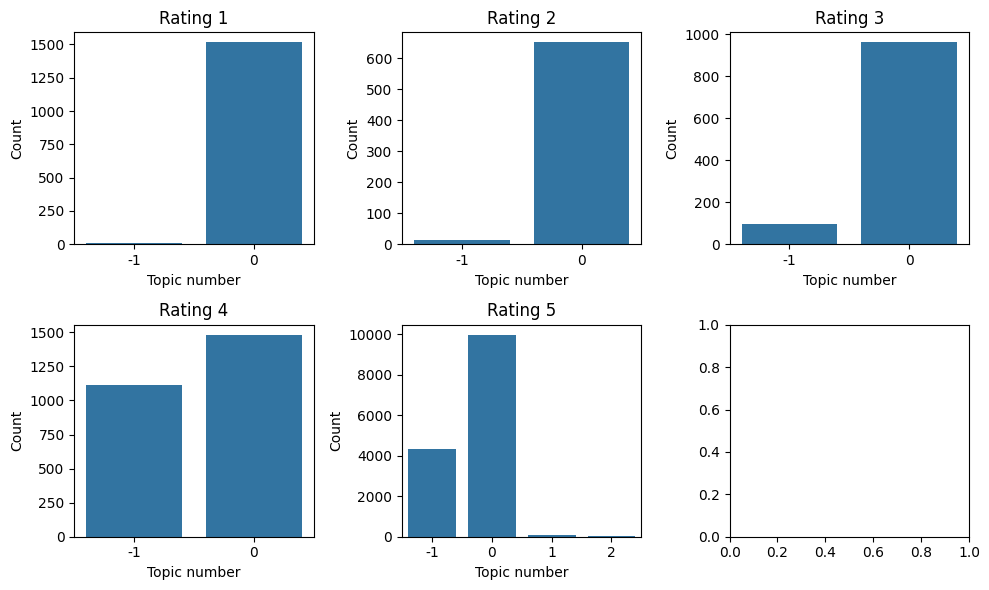

In [39]:
# visualize distribution of topics, one plot per rating arranged in grid with 2 rows and 3 columns
import seaborn as sns

# create grid of plots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# iterate over ratings and plot distribution of topics using count column
for i, rating in enumerate(range(1, 6)):
    ax = axs[i // 3, i % 3]
    sns.barplot(x='topic_number', y='count', data=df_topics[df_topics['star_rating'] == rating], ax=ax)
    ax.set_title(f'Rating {rating}')
    ax.set_xlabel('Topic number')
    ax.set_ylabel('Count')

# Display all subplots together
plt.tight_layout()
plt.show()

# generate phrases for topics

In [40]:
import os
from groq import Groq 

# Initialize the client
client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

# Define the system message
system_message = """
Generate a concise and coherent phrase that summarizes topics based on provided keywords
and associated review ratings. The keywords are ordered by relevance from the most to the least.

Ensure that each phrase accurately reflects the sentiment implied by the rating and highlights key aspects of the topic. 
For example, a rating of 1 should convey dissatisfaction or issues, while a rating of 5 should express satisfaction or positive feedback. 
Omit pronouns and conjunctions to keep the phrase succinct.

For reviews with low ratings (1-2) or with negative keywords, focus on problematic aspects such as defects, damages, or poor quality and 
be as detailed as possible.

Output only the phrase without additional commentary.

Example:

Input: "leak box, return, item, bottle leak, arrive damage, box, arrive, damage leak, damage, leak" Rating: 1
Output: "Leaking or damaged items and boxes upon delivery"
"""

def process_input(top_words, rating):
    user_message = f'Input: "{top_words}" rating: {rating}'
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_message
            },
            {
                "role": "user",
                "content": user_message
            }
        ],
        model="llama3-8b-8192",
    )
    generated_phrase = response.choices[0].message.content
    return generated_phrase

# generate phrases for each topic in df_topics and add generated phrase to new column 'phrase'
df_topics['phrase'] = df_topics.apply(lambda x: process_input(x['topic_words'], x['star_rating']), axis=1)
df_topics

,star_rating,topic_number,count,topic_words,phrase
0,1.0,-1,10,"[watery, lotion, moisture, water, bottle, prod...","""Watery lotion with poor consistency and limit..."
1,1.0,0,1515,"[lotion, fragrance, moisturizer, moisturize, c...","""Ineffective lotion and moisturizer products, ..."
2,2.0,-1,15,"[lotion, fragrance, butter, moisturization, st...","""Cocoa butter lotion with perfume issues"""
3,2.0,0,651,"[lotion, moisturize, fragrance, moisturizing, ...","""Moisturizing lotion and cream with decent fra..."
4,3.0,-1,97,"[lotion, moisturize, moisturizer, cream, skin,...",Effective moisturizing and hydration product
5,3.0,0,962,"[lotion, moisturize, moisturizing, moisturizer...","""Effective moisturizing lotion with pleasant s..."
6,4.0,-1,1116,"[lotion, moisturize, moisturizer, moisturizing...",Effective moisturizing lotion for hydrated ski...
7,4.0,0,1481,"[lotion, moisturize, moisturizing, moisturise,...",Effective moisturizing cream for dry skin
8,5.0,-1,4325,"[moisturize, moisturizing, moisturizer, lotion...","""Effective moisturizing lotion for hydrated dr..."
9,5.0,0,9967,"[lotion, moisturize, moisturizing, moisturizer...",Moisturizing lotion and cream for oily skin wi...


In [41]:
# merge star_rating from df with labeled_reviews, drop review_text column
labeled_reviews = labeled_reviews.merge(df[['review_text', 'star_rating']], left_on='Document', right_on='review_text', how='left').drop(columns=['review_text'])
labeled_reviews

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,star_rating
0,no retinol list on ingredient list,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False,1.0
1,same as everyone else… the change theyve make ...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False,1.0
2,if youre look for something that smell good th...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False,1.0
3,use this on my arm and leg have a strange text...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False,1.0
4,i didnt get this because my shopper decide the...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False,1.0
...,...,...,...,...,...,...,...,...,...
20276,i feel this be one of the best lotion out ther...,-1,-1_moisturize_moisturizing_moisturizer_lotion,"[moisturize, moisturizing, moisturizer, lotion...",[this aveeno body lotion be great for my dry w...,moisturize - moisturizing - moisturizer - loti...,0.000000,False,5.0
20277,love this lotion use it on a daily basis and i...,-1,-1_moisturize_moisturizing_moisturizer_lotion,"[moisturize, moisturizing, moisturizer, lotion...",[this aveeno body lotion be great for my dry w...,moisturize - moisturizing - moisturizer - loti...,0.000000,False,5.0
20278,this lotion be one of the best lotion i have e...,0,0_lotion_moisturize_moisturizing_moisturizer,"[lotion, moisturize, moisturizing, moisturizer...",[aveeno be always best lotion for my skin i do...,lotion - moisturize - moisturizing - moisturiz...,0.929443,False,5.0
20279,i be in love with this lotion it make my skin ...,-1,-1_moisturize_moisturizing_moisturizer_lotion,"[moisturize, moisturizing, moisturizer, lotion...",[this aveeno body lotion be great for my dry w...,moisturize - moisturizing - moisturizer - loti...,0.000000,False,5.0


In [42]:
# merge phrases with labeled_reviews
labeled_reviews = labeled_reviews.merge(df_topics[['star_rating', 'topic_number', 'phrase']], left_on=['Topic', 'star_rating'], right_on=['topic_number', 'star_rating'], how='left').drop(columns=['topic_number'])
labeled_reviews

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,star_rating,phrase
0,no retinol list on ingredient list,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False,1.0,"""Ineffective lotion and moisturizer products, ..."
1,same as everyone else… the change theyve make ...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False,1.0,"""Ineffective lotion and moisturizer products, ..."
2,if youre look for something that smell good th...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False,1.0,"""Ineffective lotion and moisturizer products, ..."
3,use this on my arm and leg have a strange text...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False,1.0,"""Ineffective lotion and moisturizer products, ..."
4,i didnt get this because my shopper decide the...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False,1.0,"""Ineffective lotion and moisturizer products, ..."
...,...,...,...,...,...,...,...,...,...,...
20276,i feel this be one of the best lotion out ther...,-1,-1_moisturize_moisturizing_moisturizer_lotion,"[moisturize, moisturizing, moisturizer, lotion...",[this aveeno body lotion be great for my dry w...,moisturize - moisturizing - moisturizer - loti...,0.000000,False,5.0,"""Effective moisturizing lotion for hydrated dr..."
20277,love this lotion use it on a daily basis and i...,-1,-1_moisturize_moisturizing_moisturizer_lotion,"[moisturize, moisturizing, moisturizer, lotion...",[this aveeno body lotion be great for my dry w...,moisturize - moisturizing - moisturizer - loti...,0.000000,False,5.0,"""Effective moisturizing lotion for hydrated dr..."
20278,this lotion be one of the best lotion i have e...,0,0_lotion_moisturize_moisturizing_moisturizer,"[lotion, moisturize, moisturizing, moisturizer...",[aveeno be always best lotion for my skin i do...,lotion - moisturize - moisturizing - moisturiz...,0.929443,False,5.0,Moisturizing lotion and cream for oily skin wi...
20279,i be in love with this lotion it make my skin ...,-1,-1_moisturize_moisturizing_moisturizer_lotion,"[moisturize, moisturizing, moisturizer, lotion...",[this aveeno body lotion be great for my dry w...,moisturize - moisturizing - moisturizer - loti...,0.000000,False,5.0,"""Effective moisturizing lotion for hydrated dr..."


In [43]:
#drop outliers
labeled_reviews = labeled_reviews[labeled_reviews['Topic'] != -1]
labeled_reviews

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,star_rating,phrase
0,no retinol list on ingredient list,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False,1.0,"""Ineffective lotion and moisturizer products, ..."
1,same as everyone else… the change theyve make ...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False,1.0,"""Ineffective lotion and moisturizer products, ..."
2,if youre look for something that smell good th...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False,1.0,"""Ineffective lotion and moisturizer products, ..."
3,use this on my arm and leg have a strange text...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False,1.0,"""Ineffective lotion and moisturizer products, ..."
4,i didnt get this because my shopper decide the...,0,0_lotion_fragrance_moisturizer_moisturize,"[lotion, fragrance, moisturizer, moisturize, c...",[i have be use this product for year i would a...,lotion - fragrance - moisturizer - moisturize ...,1.000000,False,1.0,"""Ineffective lotion and moisturizer products, ..."
...,...,...,...,...,...,...,...,...,...,...
20273,it do a great job keep me hydrate during the w...,0,0_lotion_moisturize_moisturizing_moisturizer,"[lotion, moisturize, moisturizing, moisturizer...",[aveeno be always best lotion for my skin i do...,lotion - moisturize - moisturizing - moisturiz...,0.794285,False,5.0,Moisturizing lotion and cream for oily skin wi...
20274,ive use this product everyday for the past 20 ...,0,0_lotion_moisturize_moisturizing_moisturizer,"[lotion, moisturize, moisturizing, moisturizer...",[aveeno be always best lotion for my skin i do...,lotion - moisturize - moisturizing - moisturiz...,1.000000,False,5.0,Moisturizing lotion and cream for oily skin wi...
20275,this be simply heavensent make me want to show...,0,0_lotion_moisturize_moisturizing_moisturizer,"[lotion, moisturize, moisturizing, moisturizer...",[aveeno be always best lotion for my skin i do...,lotion - moisturize - moisturizing - moisturiz...,0.629217,False,5.0,Moisturizing lotion and cream for oily skin wi...
20278,this lotion be one of the best lotion i have e...,0,0_lotion_moisturize_moisturizing_moisturizer,"[lotion, moisturize, moisturizing, moisturizer...",[aveeno be always best lotion for my skin i do...,lotion - moisturize - moisturizing - moisturiz...,0.929443,False,5.0,Moisturizing lotion and cream for oily skin wi...


# evaluate quality of generated phrases

In [44]:
# use sentence transformers to get similarity score between reviews and generated phrases
from sentence_transformers import SentenceTransformer
from torch.nn.functional import cosine_similarity

def similarity_scores(model_name, df):
    model = SentenceTransformer(model_name)
    reviews = df['Document'].tolist()
    phrases = df['phrase'].tolist()
    review_embeddings = model.encode(reviews, convert_to_tensor=True)
    phrase_embeddings = model.encode(phrases, convert_to_tensor=True)
    similarity_scores = cosine_similarity(review_embeddings, phrase_embeddings).cpu().numpy()
    return similarity_scores


In [45]:
import time

model = 'all-MiniLM-L6-v2'
sampled = labeled_reviews.groupby(['star_rating', 'Topic']).apply(lambda x: x.sample(min(len(x), 50))).reset_index(drop=True)
start = time.time()
scores = similarity_scores(model, sampled)
end = time.time()
sampled['similarity_score'] = scores
print(f"Time taken for {model}: {end - start}")

/var/folders/x2/lsyflj4j07jc1sb3w3hfgmjc0000gn/T/ipykernel_24053/1516210873.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = labeled_reviews.groupby(['star_rating', 'Topic']).apply(lambda x: x.sample(min(len(x), 50))).reset_index(drop=True)


Time taken for all-MiniLM-L6-v2: 3.320901870727539


In [46]:
# print average similarity score for each rating/topic
avg_scores = sampled.groupby(['star_rating', 'Topic'])['similarity_score'].mean().reset_index()
avg_scores

,star_rating,Topic,similarity_score
0,1.0,0,0.429674
1,2.0,0,0.413067
2,3.0,0,0.464377
3,4.0,0,0.435148
4,5.0,0,0.460779
5,5.0,1,0.529508
6,5.0,2,0.144675


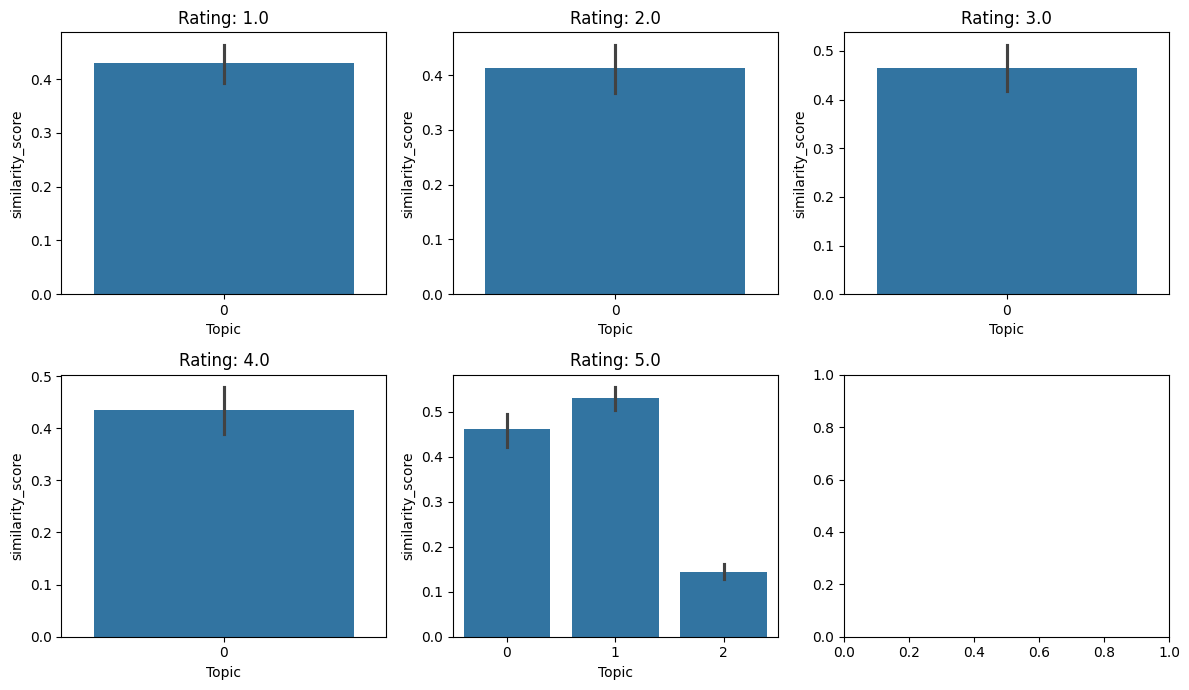

In [47]:
# visualize average similarity scores for each rating/topic
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

for rating in sampled['star_rating'].unique():
    row = int((rating - 1) // 3)
    col = int((rating - 1) % 3)
    ax = axs[row][col]
    sns.barplot(data=sampled[sampled['star_rating'] == rating], x='Topic', y='similarity_score', ax=ax)
    ax.set_title(f"Rating: {rating}")
plt.tight_layout()

In [48]:
# keep Document, phrase, Topic, star_rating, Top_n_words, similarity_score, and standardize column names
to_save = sampled[['Document', 'phrase', 'Topic', 'star_rating', 'Top_n_words', 'similarity_score']]
to_save.columns = ['review_text', 'topic_phrase', 'topic_number', 'star_rating', 'topic_words', 'similarity_score']
to_save.to_csv(f'outputs/bertopic_{label}_topics.csv', index=False)